# Projeto Análise de Vendas 

#### Imports e base de dados

In [1293]:
# gerais
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# series temporais
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error


In [1295]:
url = 'https://raw.githubusercontent.com/Seunfunmee/Retail-Sales-Data-Set/refs/heads/main/Retail%20Sales%20Data%20Set.csv'
df = pd.read_csv(url)
df.head(3)

,Transaction ID,Date,Gender,Age,Age Group,Product Category,Quantity,Price per Unit,Total Amount,Unnamed: 9,...,Unnamed: 14,Unnamed: 15,Unnamed: 16,Min_age,Max_age,Avg_age,Total Sales Revenue,Average Order value,Category,Sales
0,1,11/24/2023,Male,34,Middle Age,Beauty,3,50,150,NaN,...,NaN,NaN,NaN,18.0,64.0,41.0,456000.0,456.0,Electronics,156905.0
1,2,2/27/2023,Female,26,Adolescent,Clothing,2,500,1000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Clothing,155580.0
2,3,1/13/2023,Male,50,Middle Age,Electronics,1,30,30,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Beauty,143515.0


## Análise exploratória

In [1299]:
# as colunas Unnamed de 9 a 16 são espaços para melhorar a vizualizão quando na planilha, para essa análise elas serão dropadas
# drop das colunas não usadas

colunas_removidas = ['Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12',
                    'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16']
df = df.drop(columns = colunas_removidas) 
df.head(2)

,Transaction ID,Date,Gender,Age,Age Group,Product Category,Quantity,Price per Unit,Total Amount,Min_age,Max_age,Avg_age,Total Sales Revenue,Average Order value,Category,Sales
0,1,11/24/2023,Male,34,Middle Age,Beauty,3,50,150,18.0,64.0,41.0,456000.0,456.0,Electronics,156905.0
1,2,2/27/2023,Female,26,Adolescent,Clothing,2,500,1000,NaN,NaN,NaN,NaN,NaN,Clothing,155580.0


In [1301]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Transaction ID       1000 non-null   int64  
 1   Date                 1000 non-null   object 
 2   Gender               1000 non-null   object 
 3   Age                  1000 non-null   int64  
 4   Age Group            1000 non-null   object 
 5   Product Category     1000 non-null   object 
 6   Quantity             1000 non-null   int64  
 7   Price per Unit       1000 non-null   int64  
 8   Total Amount         1000 non-null   int64  
 9   Min_age              1 non-null      float64
 10  Max_age              1 non-null      float64
 11  Avg_age              1 non-null      float64
 12  Total Sales Revenue  1 non-null      float64
 13  Average Order value  1 non-null      float64
 14   Category            3 non-null      object 
 15  Sales                3 non-null      fl

In [1303]:
# drop das colunas min_age, mas_age e Avg_age por guardarem somente o valor minimo, maximo e a media das idades 

colunas_removidas = ['Min_age', 'Max_age', 'Avg_age']
df = df.drop(columns = colunas_removidas) 
df.head(2)

,Transaction ID,Date,Gender,Age,Age Group,Product Category,Quantity,Price per Unit,Total Amount,Total Sales Revenue,Average Order value,Category,Sales
0,1,11/24/2023,Male,34,Middle Age,Beauty,3,50,150,456000.0,456.0,Electronics,156905.0
1,2,2/27/2023,Female,26,Adolescent,Clothing,2,500,1000,NaN,NaN,Clothing,155580.0


In [1305]:
# entendendo coluna Total Sales Revenue
# se trata do valor total vendido, ou seja o valor vendido em toda a base
igual_total_sale_revenue = df['Total Amount'].sum()
igual_total_sale_revenue

456000

In [1307]:
# removendo Total Sales Revenue e category, category só armazena as categorias possiveis na base
# como a coluna Sales armazena somente o velor total vendido por categoria não usarei ela

colunas_usadas = ['Transaction ID', 'Date', 'Gender', 'Age', 'Age Group', 'Product Category', 'Quantity', 'Price per Unit',
                     'Total Amount', 'Average Order value']
df_vendas = df[colunas_usadas]
df_vendas.head(2)

,Transaction ID,Date,Gender,Age,Age Group,Product Category,Quantity,Price per Unit,Total Amount,Average Order value
0,1,11/24/2023,Male,34,Middle Age,Beauty,3,50,150,456.0
1,2,2/27/2023,Female,26,Adolescent,Clothing,2,500,1000,NaN


In [1309]:
# analisando se houveram clientes que fizeram mais de uma compra
# como o df só tem 1000 registros (linhas) e a soma deu 1000 isso siguinifica que cada cliente só fez uma compra
# ou seja o valor da coluna Average Order value não armazena a media do peido

mais_de_uma_compra = df_vendas['Transaction ID'].value_counts()
mais_de_uma_compra.sum()

1000

In [1311]:
# talvez a coluna Average Order value seja media por categoria?

grupo_catg = df_vendas.groupby('Product Category').agg(
    Total_Amount=pd.NamedAgg(column='Total Amount', aggfunc='mean')
).reset_index().round(2)
grupo_catg

,Product Category,Total_Amount
0,Beauty,467.48
1,Clothing,443.25
2,Electronics,458.79


In [1313]:
# talvez a coluna Average Order value seja media por grupo de idade?

grupo_idade = df_vendas.groupby('Age Group').agg(
    Total_Amount=pd.NamedAgg(column='Total Amount', aggfunc='mean')
).reset_index().round(2)
grupo_idade

,Age Group,Total_Amount
0,Adolescent,485.31
1,Middle Age,455.31
2,Old,417.55


In [1315]:
# Devido a falta de informações e relevancia da coluna Average Order value ela sera descontinuada na analise

df_vendas = df_vendas.drop(columns = ['Average Order value'])
df_vendas.head(2)

,Transaction ID,Date,Gender,Age,Age Group,Product Category,Quantity,Price per Unit,Total Amount
0,1,11/24/2023,Male,34,Middle Age,Beauty,3,50,150
1,2,2/27/2023,Female,26,Adolescent,Clothing,2,500,1000


In [1317]:
# qual a categoria de produtos com mais lucro?
# pouca diferença entre as categorias

melhor_categ = df_vendas.groupby('Product Category').agg(
    lucro = pd.NamedAgg(column='Total Amount', aggfunc='sum')
).reset_index()

melhor_categ

,Product Category,lucro
0,Beauty,143515
1,Clothing,155580
2,Electronics,156905


In [1319]:
# qual o grupo de idades que mais gastam?

# criando total_vendas
total_vendas = df_vendas['Total Amount'].sum()

melhor_group_age = df_vendas.groupby('Age Group').agg(
    vendas = pd.NamedAgg(column='Total Amount',aggfunc='sum')
).reset_index()

# criando coluna porcem que guarda a porcentagem das vendas em relação ao valor total
melhor_group_age['porcem'] = (melhor_group_age['vendas'] / total_vendas) *100 

melhor_group_age.round(2)

,Age Group,vendas,porcem
0,Adolescent,143165,31.40
1,Middle Age,222645,48.83
2,Old,90190,19.78


O grupo de pessoas que mais consome nossos produtos são Middle Age

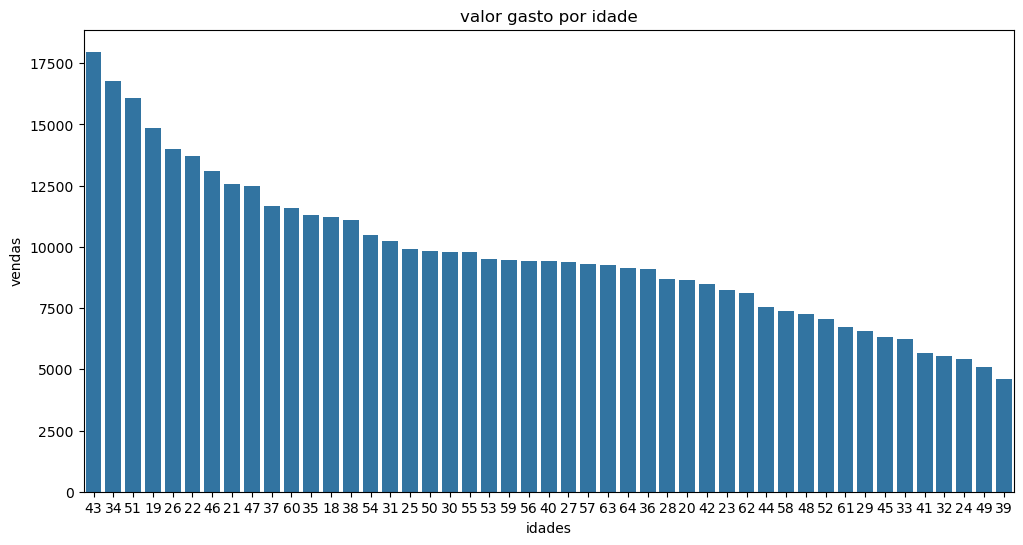

In [1322]:
# qual a idade que mais gastam?

melhor_age = df_vendas.groupby('Age').agg(
    vendas = pd.NamedAgg(column='Total Amount',aggfunc='sum')
).reset_index()

# criando grafico de lihas para melhor visualização
plt.figure(figsize=(12,6))
sns.barplot(x='Age', y='vendas', data=melhor_age, 
            order=melhor_age.sort_values('vendas', ascending=False)['Age'])

plt.title('valor gasto por idade')
plt.xlabel('idades')
plt.ylabel('vendas')

plt.show()

<Axes: xlabel='Product Category', ylabel='Total Amount'>

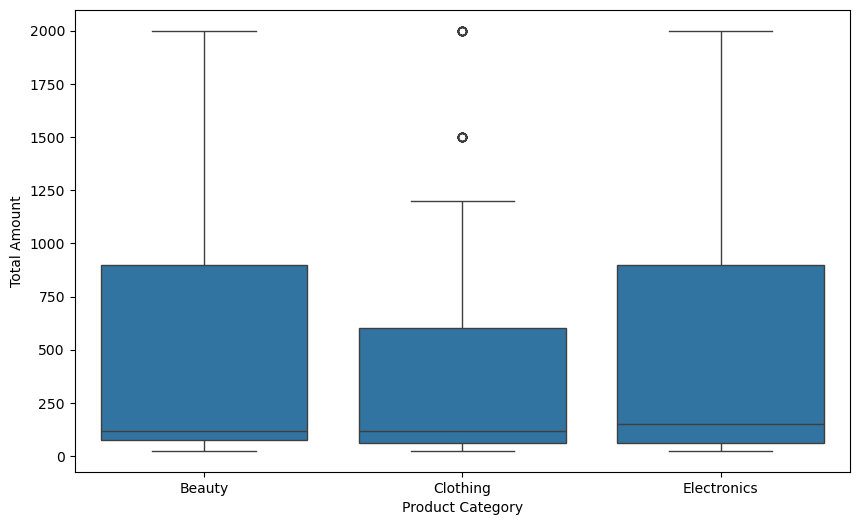

In [1324]:
# procurando outliers

plt.figure(figsize=(10, 6))
sns.boxplot(x='Product Category', y='Total Amount', data=df_vendas)

In [1326]:
# Filtrando o DataFrame para a categoria 'Clothing'
df_clothing = df_vendas[df_vendas['Product Category'] == 'Clothing']

# Calculando os quartis e o IQR para 'Total Amount' apenas para Clothing
Q1_clothing = df_clothing['Total Amount'].quantile(0.25)
Q3_clothing = df_clothing['Total Amount'].quantile(0.75)
IQR_clothing = Q3_clothing - Q1_clothing

# Definindo os limites para outliers na categoria Clothing
limite_inferior_clothing = Q1_clothing - 1.5 * IQR_clothing
limite_superior_clothing = Q3_clothing + 1.5 * IQR_clothing

# Filtrando os outliers para a categoria Clothing
outliers_clothing = df_clothing[(df_clothing['Total Amount'] < limite_inferior_clothing) | 
                                (df_clothing['Total Amount'] > limite_superior_clothing)]
print("Outliers na categoria Clothing:")
outliers_clothing.head()

Outliers na categoria Clothing:


,Transaction ID,Date,Gender,Age,Age Group,Product Category,Quantity,Price per Unit,Total Amount
15,16,2/17/2023,Male,19,Adolescent,Clothing,3,500,1500
77,78,7/1/2023,Female,47,Middle Age,Clothing,3,500,1500
111,112,12/2/2023,Male,37,Middle Age,Clothing,3,500,1500
114,115,11/26/2023,Male,51,Middle Age,Clothing,3,500,1500
123,124,10/27/2023,Male,33,Middle Age,Clothing,4,500,2000


In [1328]:
# Obter os índices dos outliers na categoria 'Clothing'
outliers_indices_clothing = outliers_clothing.index

# Remover os outliers do DataFrame original
df_vendas = df_vendas.drop(index=outliers_indices_clothing)

In [1331]:
# Garantir que a coluna 'Date' seja do tipo datetime
df_vendas['Date'] = pd.to_datetime(df_vendas['Date'])

# Selecionar apenas os dados de 2023
df_vendas = df_vendas[df_vendas['Date'].dt.year == 2023]

# Agrupar por dia (mantendo Date como datetime)
grupo_semana = df_vendas.groupby('Date').agg(
    Total_Amount=pd.NamedAgg(column='Total Amount', aggfunc='sum')
)
grupo_semana = grupo_semana.sort_index()
grupo_semana.head()

,Total_Amount
Date,
2023-01-01,3600
2023-01-02,265
2023-01-03,600
2023-01-04,1240
2023-01-05,1100


## Modelo ARIMA

### Integracao I ----- (d)

 -- Tornando a base estacionaria

In [1336]:
# o index 0 contem um nan apos a alteração
base_adf = adfuller(grupo_semana['Total_Amount'].diff().dropna())

    # valor da estatistica

print('Estatística ADF: {:.4}'.format(base_adf[0]))
# p value

print('p-value: {:.4}'.format(base_adf[1]))
# grafico


Estatística ADF: -8.021
p-value: 2.077e-12


<Axes: xlabel='Date'>

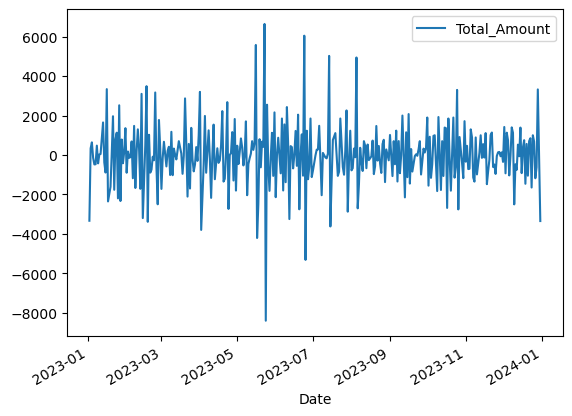

In [1338]:
grupo_semana.diff().plot()

### Modelo AR - PACF ----- (p)

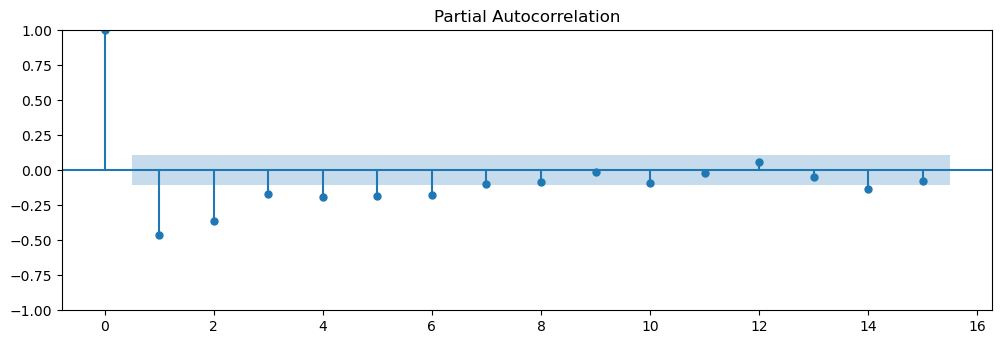

In [1342]:
# criando grafico de PACF

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_pacf(grupo_semana['Total_Amount'].diff().dropna(),lags=15,ax=ax1)


*Para o valor de (p) vou considerar só ate 3*

### Modelo MA - ACF ----- (q)

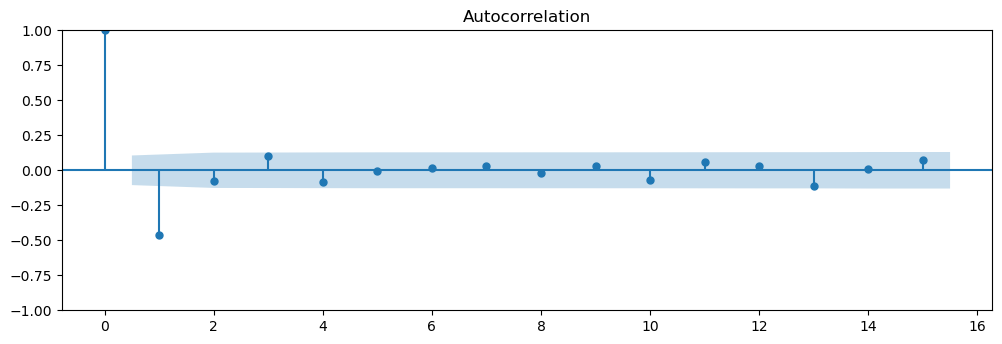

In [1346]:
#criando grafico de ACF

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(grupo_semana['Total_Amount'].diff().dropna(),lags=15,ax=ax1)

### Treinar modelo ARIMA (p ,d, q)
- Vamos avaliar um ARIMA (3, 1, 1)

- Separando treino e teste

In [1355]:
test_size = int(0.2 * len(grupo_semana))  # 20% dos dados para teste

trein = grupo_semana[:-test_size]  # 80% para treino

test = grupo_semana[-test_size:] # 20% para teste

In [1357]:
test.shape

(68, 1)

In [1359]:
# Modelo arima

modelo_AR = ARIMA(grupo_semana['Total_Amount'].values, order=(3, 1, 1), trend = 'n').fit()

In [1361]:
modelo_AR.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  344
Model:                 ARIMA(3, 1, 1)   Log Likelihood               -2898.415
Date:                Wed, 26 Mar 2025   AIC                           5806.830
Time:                        11:54:32   BIC                           5826.018
Sample:                             0   HQIC                          5814.473
                                - 344                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0239      0.054      0.445      0.656      -0.081       0.129
ar.L2         -0.0375      0.060     -0.627      0.531      -0.155       0.080
ar.L3          0.0460      0.071      0.646      0.518      -0.093       0.185
ma.L1         -1.0000      0.035    -28.551      0.000      -1.069      -0.931
sigma2      1.264e+06   2.77e-08   4.56e+13      0.000    1.26e+06    1.26e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):              1318.21
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               0.76   Skew:                             2.22
Prob(H) (two-sided):                  0.15   Kurtosis:                        11.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.23e+28. Standard errors may be unstable.
"""

Avaliando modelo

ACF

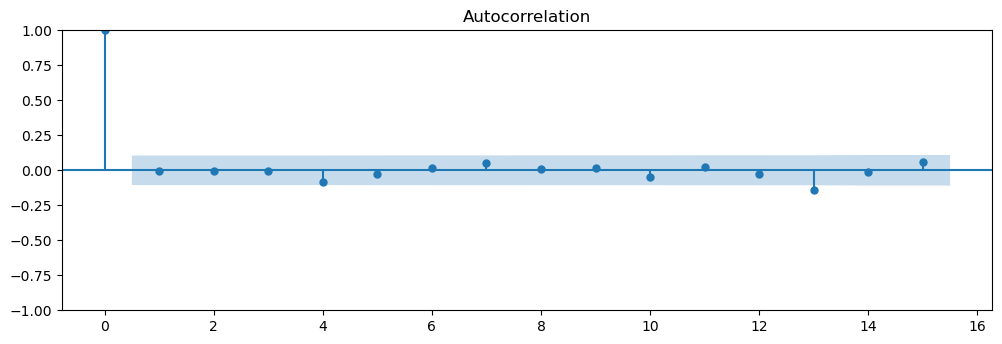

In [1366]:
# ACF 

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(modelo_AR.resid, lags=15,ax=ax1)

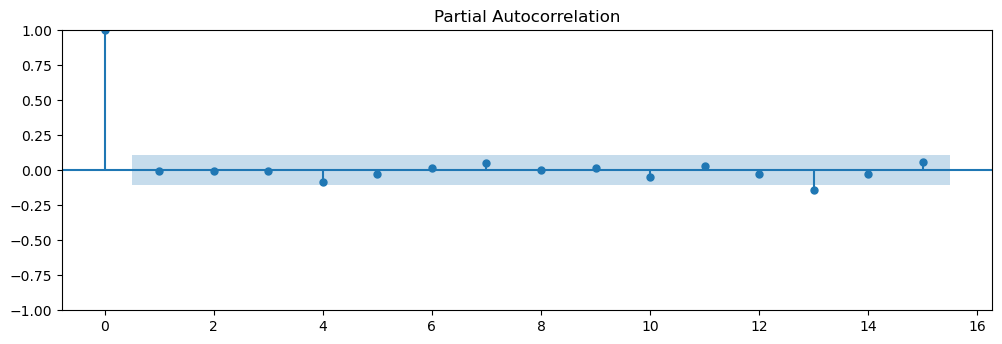

In [1368]:
# ACF 


fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_pacf(modelo_AR.resid, lags=15,ax=ax1)

### Avaliação na amostra de teste 

In [1371]:
trein.tail(), trein.shape

(            Total_Amount
 Date                    
 2023-10-17           175
 2023-10-18          2025
 2023-10-19          1860
 2023-10-20            50
 2023-10-21            50,
 (276, 1))

In [1373]:

predicao_bruta = modelo_AR.predict(start=276, end=343, dynamic=False)

In [1375]:

ultimo_valor = trein['Total_Amount'].iloc[-1]

In [1377]:

predicao = np.cumsum(np.append(ultimo_valor, predicao_bruta))

In [1379]:

predicao = np.delete(predicao, 0)

Metricas de avaliação

In [1387]:
test = test.copy()
test["predição"] = predicao
test.head(2)

,Total_Amount,predição
Date,,
2023-10-22,1950,1241.884535
2023-10-23,800,2398.592945


In [1389]:
grupo_semana.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 344 entries, 2023-01-01 to 2023-12-31
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   Total_Amount  344 non-null    int64
dtypes: int64(1)
memory usage: 5.4 KB


In [1391]:
dados_reais = trein['Total_Amount'].values

In [1278]:

#rmse = np.sqrt(mean_squared_error(dados_reais, predicao))

In [1280]:
#mape = mean_absolute_percentage_error(dados_reais, predicao)



In [1282]:
print(f'''
    RMSE = {rmse}
    MAPE = {mape}
    MAE = {mae}
''')

NameError: name 'rmse' is not defined

In [1393]:
# Verificando o comprimento de dados reais e predições
print(len(dados_reais), len(predicao))

# Garantir que as predições correspondem ao tamanho dos dados reais
if len(dados_reais) == len(predicao):
    rmse = np.sqrt(mean_squared_error(dados_reais, predicao))
    print(f'RMSE: {rmse}')
else:
    print("Erro: Os tamanhos dos dados reais e das predições são diferentes!")


276 68
Erro: Os tamanhos dos dados reais e das predições são diferentes!
